In [1]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import os


In [2]:
# 开启 LangSmith 跟踪，便于调试和查看详细执行信息
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ChatBotVote"

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

chat_model = ChatOpenAI(model="gpt-4o-mini")

In [4]:
def chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])]}

In [5]:
def translate_to_chinese(input: dict):
    content = input["messages"][-1].content
    return {"messages": [chat_model.invoke([
            ("system", "Translate the following text to Chinese: "),
            ("user", content),
            ]
    )]} 

In [6]:
graph_builder = StateGraph(State)

# 添加节点
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("translate_to_chinese", translate_to_chinese)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "translate_to_chinese")
graph_builder.add_edge("translate_to_chinese", END)

graph = graph_builder.compile()

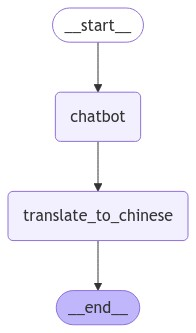

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
# 选举问题。
vote_question = "Today is {current_date}, who was win the US presidential election on November 5, 2024?"

In [9]:
for event in graph.stream({"messages": [("user", vote_question)]}):
    # 遍历每个事件的值
    for value in event.values():
        #print("Assistant:", value)
        print("Assistant:", value['messages'][-1].content)

Assistant: I'm sorry, but I don't have access to real-time data or future events, including the results of elections. As of my last update in October 2023, I can't predict the outcome of the 2024 US presidential election. For the most current information, please check reliable news sources or official announcements closer to the date.
Assistant: 抱歉，我无法访问实时数据或未来事件，包括选举结果。根据我在2023年10月的最后更新，我无法预测2024年美国总统选举的结果。有关最新信息，请在接近日期时查看可靠的新闻来源或官方公告。
